In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import (
    backend as K,
    losses,
    optimizers,
    layers,
    models,
    utils,
    callbacks
)

from pathlib import Path

## Import Data

In [5]:
data_dir = "/Users/muhammedrashid/Documents/codeme/interns/Fracture Detection/Bone Break Classification"

# load the train data

train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)

#load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [6]:
# Inspect class names
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [7]:
# data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [8]:
# get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    #append train data to x_train
    x_train.append(images.numpy())
    
    #append labels to y_train
    y_train.append(labels.numpy())
    
# concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

2025-08-18 13:55:39.322020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# get val data and labels

x_val = []
y_val = []

for images, labels in val_dataset:
    #append train data to x_train
    x_val.append(images.numpy())
    
    #append labels to y_train
    y_val.append(labels.numpy())
    
# concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

2025-08-18 13:55:39.486307: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# get single batch from train data

def sample_batch(data):
    batch = data.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [11]:
class_names_dict = {
    0: 'Avulsion fracture', 
    1: 'Comminuted fracture', 
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [12]:
# function to display images

def display(images, n=10, size=(15,5), cmap="gray_r", as_type="float32"):
    indices = np.random.choice(len(images), n)
    
    num_images_per_row = 4
    
    num_rows = (n + num_images_per_row - 1) // num_images_per_row
    
    # Set up the subplots
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=size)

    #plt.figure(figsize=size)
    for i, index in enumerate(indices):
        #plt.subplot(1, n, i+1)
        
        label_index = y_train[index]
    
        # Convert integer label to class name
        class_name = class_names_dict.get(label_index, f'Unknown Class {label_index}')
    
          # Calculate the position of the subplot in the grid
        row = i // num_images_per_row
        col = i % num_images_per_row
    
        axes[row, col].imshow(images[index].astype(as_type), cmap=cmap)
        axes[row, col].set_title(f'Class: {label_index}')
        axes[row, col].axis('off')
        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.show()

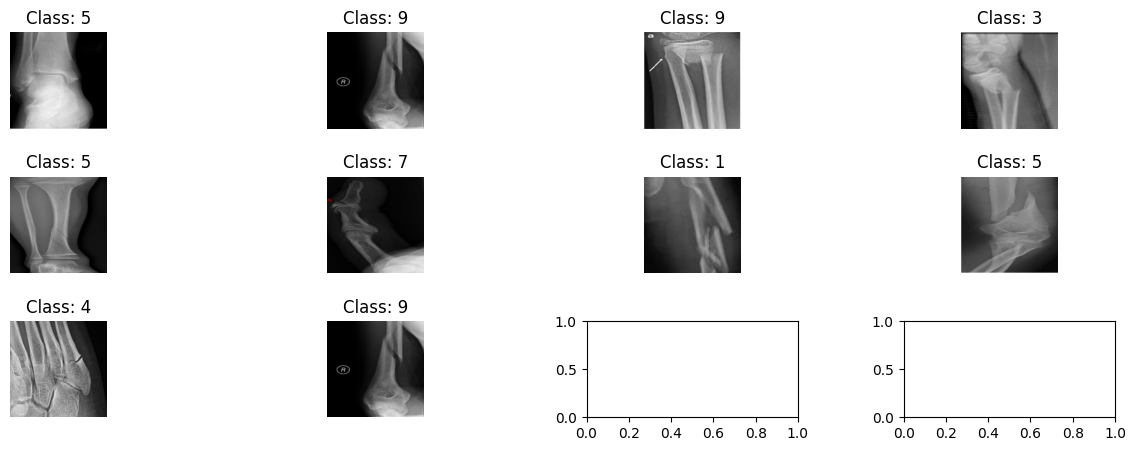

In [13]:
# display sample train images

sample_images = x_train[:100]

display(sample_images)

In [14]:
# view tensor shape

x_train.shape

(1017, 256, 256, 3)

In [15]:
# one-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

## MLP

In [16]:
input_layer = layers.Input(shape=(256, 256, 3), name="input_layer")

# Flatten to Vector before inputing in Dense Layer

x = layers.Flatten()(input_layer)

x = layers.Dense(units=300)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=250)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=200)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=150)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │    58,982,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │        75,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250)            │         1,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,157,210 (225.67 MB)

 Trainable params: 59,155,810 (225.66 MB)

 Non-trainable params: 1,400 (5.47 KB)

In [17]:
# compile
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.1406 - loss: 2.4727
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.2458 - loss: 2.1075
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.2960 - loss: 1.9701
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.3510 - loss: 1.8803
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.3884 - loss: 1.7757
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.4228 - loss: 1.6933
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.4533 - loss: 1.6506
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.4808 - loss: 1.5299
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5290 - loss: 1.4209
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.5674 - loss: 1.3687
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.6254 - loss: 1.2309
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step

In [19]:
# Evaluate Model

model.evaluate(x_val, y_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6071 - loss: 1.1397 


[1.1396931409835815, 0.6071428656578064]

In [20]:
CLASSES = np.array(class_names)

preds = model.predict(x_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [21]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [22]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

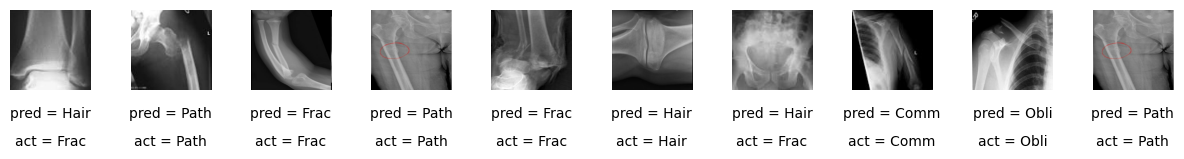

In [23]:
# predicstions with MLP
display_preds_act(n=10)

## CNN

In [24]:
input_layer = layers.Input(shape=(256,256, 3))

x = layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(input_layer)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    64,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    128,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    256,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model2 = models.Model(input_layer, output_layer)

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     6,553,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,945,446 (26.49 MB)

 Trainable params: 6,944,286 (26.49 MB)

 Non-trainable params: 1,160 (4.53 KB)

In [25]:
opt = optimizers.Adam(learning_rate=0.0005)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [27]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [28]:
history = model2.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - accuracy: 0.1701 - loss: 2.6926 - val_accuracy: 0.1518 - val_loss: 2.2718
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.3294 - loss: 1.9729 - val_accuracy: 0.4107 - val_loss: 1.9684
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.4926 - loss: 1.5216 - val_accuracy: 0.5893 - val_loss: 1.2682
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.6637 - loss: 1.0662 - val_accuracy: 0.7768 - val_loss: 0.8304
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.8358 - loss: 0.5966 - val_accuracy: 0.8929 - val_loss: 0.5380
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.9420 - loss: 0.3581 - val_accuracy: 0.9375 - val_loss: 0.2990
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.9646 - loss: 0.2338 - val_accuracy: 0.9464 - val_loss: 0.2644
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.9823 - loss: 0.1560 - val_accuracy: 0

In [29]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

In [30]:
model2.evaluate(x_val, y_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9464 - loss: 0.2033


[0.20327794551849365, 0.9464285969734192]

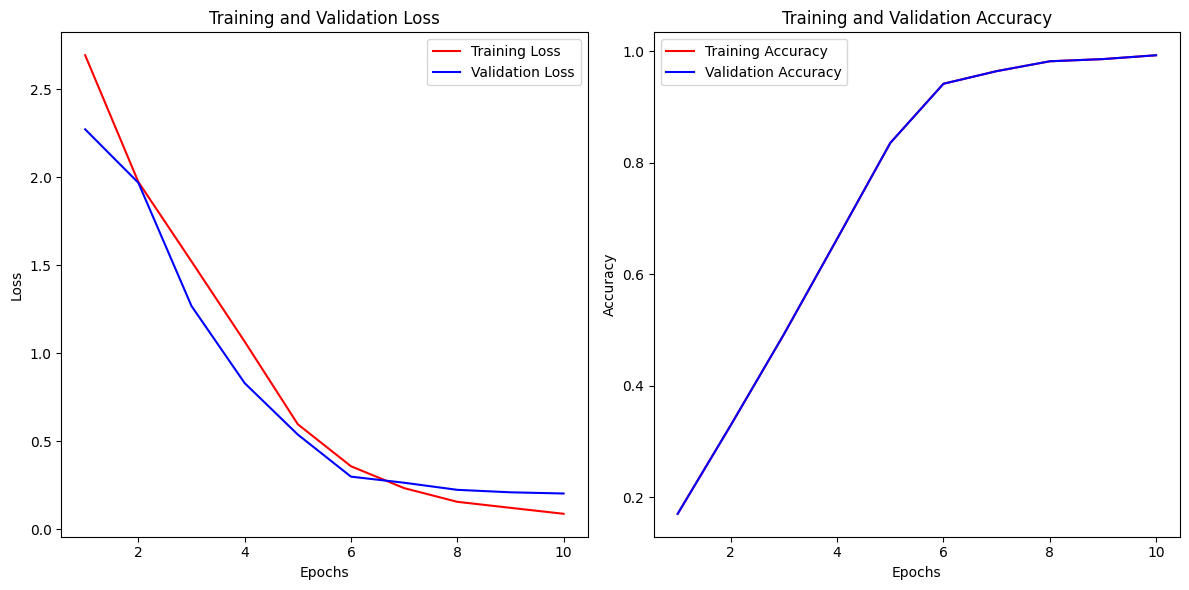

In [31]:
# plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
#predictions

preds = model2.predict(x_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [33]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

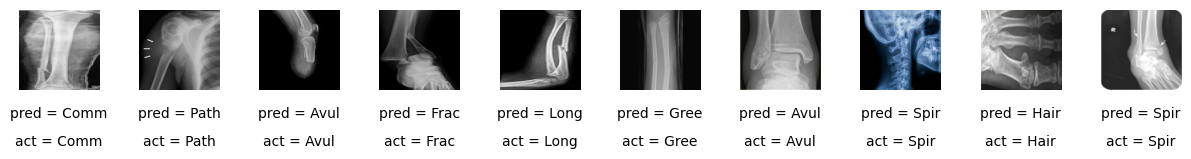

In [34]:
#Predictions

display_preds_act()

In [35]:
model2.save("bone_break_classification_model.keras")